In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, TimeDistributed, RepeatVector, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from pykalman import KalmanFilter
import gym
import gym.spaces
import stable_baselines3 as sb3
from stable_baselines3 import PPO
from skopt import gp_minimize
from skopt.space import Integer, Real
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from ta.volatility import BollingerBands

import pywt
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report

In [2]:
# Step 1: Download the data
data = yf.download('^GSPC', start='2010-01-01', end='2025-04-12')

# Step 2: Compute indicators
data['SMA_crossover'] = data['Close'].rolling(window=200).mean() - data['Close'].rolling(window=50).mean()

def stochastic_oscillator(df, window=14):
    low_min = df['Low'].rolling(window).min()
    high_max = df['High'].rolling(window).max()
    df['%K'] = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    return df

data = stochastic_oscillator(data)

def average_true_range(df, window=14):
    high_low = df['High'] - df['Low']
    high_close = abs(df['High'] - df['Close'].shift(1))
    low_close = abs(df['Low'] - df['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR_14'] = true_range.rolling(window).mean()  # SMA of TR
    return df

data = average_true_range(data)  

def on_balance_volume(df):
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()
    return df

data = on_balance_volume(data)  # Adds OBV column

def vwap(df):
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()
    return df

data = vwap(data)  # Adds VWAP column

delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = ema_12 - ema_26

data['Return'] = data['Close'].pct_change()
data['Volatility'] = data['Return'].rolling(window=10).std()

bb_indicator = BollingerBands(close=data['Close'].squeeze(), window=20, window_dev=2)
data['BB_bandWidh'] = bb_indicator.bollinger_hband() - bb_indicator.bollinger_lband()

data['Return_3'] = data['Close'].pct_change(3).shift(1)  # 3-day cumulative return
data['Return_5'] = data['Close'].pct_change(5).shift(1)  # 5-day cumulative return
data['SMA_17'] = data['Close'].rolling(window=17).mean()
data['SMA_5'] = data['Close'].rolling(window=5).mean()
data['SMA_9'] = data['Close'].rolling(window=9).mean()
data['SMA_crossover_binary'] = (data['Close'].rolling(window=10).mean() > data['Close'].rolling(window=50).mean()).astype(int)

data['Volatility_Trend'] = data['Volatility'] - data['Volatility'].shift(1)

data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=data['Close'].shift(-3).values[0],
    initial_state_covariance=1.0,
    observation_covariance=1.0,
    transition_covariance=0.1
)
data['Target'], _ = kf.filter(data['Close'].shift(-3).values)

y = data['Target'].values.reshape(-1, 1)
data.dropna(inplace=True)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Convert one-hot or probabilities to class indices

def create_labels(y):
    labels = np.zeros((len(y), 3))
    for i in range(len(y) - 1):
        diff = y[i + 1] - y[i]
        if diff > 0.005:  # Threshold for UP
            labels[i, 0] = 1  # UP
        elif diff < -0.005:  # Threshold for DOWN
            labels[i, 1] = 1  # DOWN
        else:
            labels[i, 2] = 1  # NEUTRAL
    return labels


copy_features = ['SMA_crossover','SMA_17' ,'SMA_9','SMA_5','ATR_14', 'OBV', 'VWAP','Volume','BB_bandWidh','MACD','Volatility','Target']
features = ['SMA_crossover','SMA_17' ,'SMA_9','SMA_5','ATR_14', 'OBV', 'VWAP','Volume','BB_bandWidh','MACD','Volatility']
original_index = data[copy_features].index.copy()

date_index = data.index.copy()
class_y = np.argmax(create_labels(data['Target']), axis=1)
class_y = pd.Series(class_y, index=original_index, name='Target_Class')  # convert to Series with name


# Combine features and labels
#df = pd.concat([data[features], class_y], axis=1)

#df = pd.concat([data[copy_features].reset_index(drop=True), class_y.reset_index(drop=True)], axis=1)
df = pd.concat([data[copy_features], class_y], axis=1)

label_col = 'Target_Class'

# Upsample each class to match the largest class
max_size = df[label_col].value_counts().max()
df_upsampled = pd.DataFrame()

for class_label, group in df.groupby(label_col):
    upsampled_group = resample(group,
                               replace=True,
                               n_samples=max_size,
                               random_state=42)
    df_upsampled = pd.concat([df_upsampled, upsampled_group])

# Shuffle the result
df_upsampled = df_upsampled.sample(frac=1, random_state=42)
df_upsampled.columns = [col[0] if isinstance(col, tuple) else col for col in df_upsampled.columns]
df_upsampled = df_upsampled.sort_index()

df_upsampled.head()

# Split back to X and y
X_upsampled = df_upsampled.drop(label_col, axis=1)
y_upsampled = df_upsampled[label_col]


/var/folders/k9/ywt32ng54d766jxqldqb4y7c0000gn/T/ipykernel_99000/2432642847.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = y[i + 1] - y[i]


In [5]:
# Step 6: Scaling

X = df_upsampled[features].values
y = df_upsampled['Target']
y_class = df_upsampled['Target_Class']  


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
sequence_length =3
# Step 7: Sequence formatting for LSTM-like models
X_reshaped = np.array([X_scaled[i-sequence_length:i] for i in range(sequence_length, len(X_scaled))])
y_reshaped = y_scaled[sequence_length:]

split = int(0.9 * len(X_reshaped))
X_train_t, X_test = X_reshaped[:split], X_reshaped[split:]
y_train_t, y_test = y_reshaped[:split], y_reshaped[split:]

split = int(0.9 * len(X_train_t))
X_train, X_val = X_train_t[:split], X_train_t[split:]
y_train, y_val = y_train_t[:split], y_train_t[split:]

y_train_class = create_labels(y_train)
y_val_class = create_labels(y_val)
y_test_class = create_labels(y_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Final sanity check
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

num_features = X_train.shape[2]  # e.g., 12

# Add Wavelet Features
prices = df_upsampled['Target'].values
n = len(prices)
coeffs = pywt.wavedec(prices, 'db1', level=5)
reconstructed_details = []
for level in range(1, len(coeffs)):
    coeff_reconstruct = [np.zeros_like(c) for c in coeffs]
    coeff_reconstruct[level] = coeffs[level]
    coeff_reconstruct[0] = np.zeros_like(coeffs[0])
    reconstructed = pywt.waverec(coeff_reconstruct, 'db1')[:n]
    reconstructed_details.append(reconstructed)
wavelet_features = np.stack(reconstructed_details, axis=1)

# Align wavelet features with each split
wavelet_features_train = wavelet_features[-X_train.shape[0]:]
wavelet_features_test = wavelet_features[-X_test.shape[0]:]
wavelet_features_val = wavelet_features[-X_val.shape[0]:]

# Expand for sequence length
wavelet_features_train_expanded = np.repeat(wavelet_features_train[:, np.newaxis, :], X_train.shape[1], axis=1)
wavelet_features_test_expanded = np.repeat(wavelet_features_test[:, np.newaxis, :], X_test.shape[1], axis=1)
wavelet_features_val_expanded = np.repeat(wavelet_features_val[:, np.newaxis, :], X_val.shape[1], axis=1)

# Concatenate with input data
X_train_with_wavelet = np.concatenate([X_train, wavelet_features_train_expanded], axis=2)
X_test_with_wavelet = np.concatenate([X_test, wavelet_features_test_expanded], axis=2)
X_val_with_wavelet = np.concatenate([X_val, wavelet_features_val_expanded], axis=2)
num_features = X_train_with_wavelet.shape[2]

print("X_train_with_wavelet shape:", X_train_with_wavelet.shape)
print("X_val_with_wavelet shape:", X_val_with_wavelet.shape)        
print("X_test_with_wavelet shape:", X_test_with_wavelet.shape)


X_train shape: (5598, 3, 11)
y_train shape: (5598, 1)
X_val shape: (622, 3, 11)
y_val shape: (622, 1)
X_test shape: (692, 3, 11)
y_test shape: (692, 1)
X_train_with_wavelet shape: (5598, 3, 16)
X_val_with_wavelet shape: (622, 3, 16)
X_test_with_wavelet shape: (692, 3, 16)


In [6]:
# Custom Loss for Regression
def custom_loss(y_true, y_pred):
    error = tf.abs(y_true - y_pred)
    weight = tf.where(error > 0.05, 5.0, 1.0)
    weighted_mse = tf.reduce_mean(weight * tf.square(y_true - y_pred))
    direction = tf.reduce_mean(tf.sign(y_true[1:] - y_true[:-1]) * tf.sign(y_pred[1:] - y_pred[:-1]))
    drop_penalty = tf.reduce_mean(tf.where(y_true < y_pred, 15.0 * tf.square(y_true - y_pred), 0.0))
    actual_vol = tf.math.reduce_variance(y_true)
    pred_vol = tf.math.reduce_variance(y_pred)
    vol_penalty = tf.square(actual_vol - pred_vol)
    return weighted_mse - 0.1 * direction + 0.5 * drop_penalty + 0.2 * vol_penalty

# Focal Loss for Classification
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        return -tf.reduce_mean(alpha_t * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return focal_loss_fixed

# Updated Attention Layer
class SimpleAttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(SimpleAttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='glorot_uniform')
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros')

    def call(self, inputs):
        e = tf.keras.backend.dot(inputs, self.W) + self.b
        e = tf.keras.backend.tanh(e)
        alpha = tf.keras.backend.softmax(e, axis=1)
        context = inputs * alpha
        return context

class ImprovedAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads=4):
        super(ImprovedAttentionLayer, self).__init__()
        self.num_heads = num_heads

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.num_heads == 0
        self.depth = self.d_model // self.num_heads
        self.Wq = self.add_weight(name='Wq', shape=(self.d_model, self.d_model), initializer='glorot_uniform')
        self.Wk = self.add_weight(name='Wk', shape=(self.d_model, self.d_model), initializer='glorot_uniform')
        self.Wv = self.add_weight(name='Wv', shape=(self.d_model, self.d_model), initializer='glorot_uniform')
        self.Wo = self.add_weight(name='Wo', shape=(self.d_model, self.d_model), initializer='glorot_uniform')

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        Q = tf.matmul(inputs, self.Wq)
        K = tf.matmul(inputs, self.Wk)
        V = tf.matmul(inputs, self.Wv)
        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)
        dk = tf.cast(self.depth, tf.float32)
        score = tf.matmul(Q, K, transpose_b=True) / tf.math.sqrt(dk)
        attention_weights = tf.nn.softmax(score, axis=-1)
        context = tf.matmul(attention_weights, V)
        context = tf.transpose(context, perm=[0, 2, 1, 3])
        context = tf.reshape(context, (batch_size, -1, self.d_model))
        output = tf.matmul(context, self.Wo)
        return output
    
# Updated LSTM Model with GRU and Wavelet Branch
def create_lstm_model(units, dropout_rate, sequence_length, num_features, num_wavelet_features=5):
    print("Creating LSTM model with units:", units, "and dropout rate:", dropout_rate,
          "for sequence length:", sequence_length, "and num features:", num_features)
    inputs = Input(shape=(sequence_length, num_features))
    main_features = inputs[:, :, :-num_wavelet_features]
    wavelet_features = inputs[:, :, -num_wavelet_features:]

    # Main branch
    x_main = Bidirectional(LSTM(units, return_sequences=True))(main_features)
    x_main = ImprovedAttentionLayer()(x_main)
    x_main = Dropout(dropout_rate)(x_main)
    x_main = GRU(64, return_sequences=False)(x_main)
    x_main = Dropout(dropout_rate)(x_main)

    # Wavelet branch
    x_wavelet = Bidirectional(LSTM(units, return_sequences=True))(wavelet_features)
    x_wavelet = ImprovedAttentionLayer()(x_wavelet)
    x_wavelet = Dropout(dropout_rate)(x_wavelet)
    x_wavelet = GRU(64, return_sequences=False)(x_wavelet)
    x_wavelet = Dropout(dropout_rate)(x_wavelet)

    # Combine branches
    x = Concatenate()([x_main, x_wavelet])
    price_output = Dense(1, activation='linear', name='price')(x)
    class_output = Dense(3, activation='softmax', name='class')(x)  # UP/DOWN/NEUTRAL
    model = Model(inputs, outputs=[price_output, class_output])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipvalue=0.5)
    model.compile(optimizer=optimizer, 
                  loss={'price': custom_loss, 'class': focal_loss()},
                  metrics={'price': 'mae', 'class': 'accuracy'})
    return model


In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Create and train model
sequence_length = 3
lstm_model = create_lstm_model(units=128, dropout_rate=0.2, sequence_length=sequence_length, num_features=num_features, num_wavelet_features=5)
lstm_model.fit(X_train_with_wavelet, {'price': y_train, 'class': y_train_class},
          validation_data=(X_val_with_wavelet, {'price': y_val, 'class': y_val_class}),
          epochs=50, batch_size=16,callbacks=[early_stopping, reduce_lr])


Creating LSTM model with units: 128 and dropout rate: 0.2 for sequence length: 3 and num features: 16


2025-04-17 15:36:24.087299: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-17 15:36:24.087630: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-17 15:36:24.087843: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-17 15:36:24.087888: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-17 15:36:24.088223: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2025-04-17 15:36:26.753086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


350/350 ━━━━━━━━━━━━━━━━━━━━ 45s 101ms/step - class_accuracy: 0.9329 - class_loss: 0.0250 - loss: 0.1318 - price_loss: 0.1069 - price_mae: 0.1023 - val_class_accuracy: 0.8826 - val_class_loss: 0.0392 - val_loss: 0.0504 - val_price_loss: 0.0113 - val_price_mae: 0.0339 - learning_rate: 5.0000e-04
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step - class_accuracy: 0.9857 - class_loss: 0.0063 - loss: -0.0388 - price_loss: -0.0451 - price_mae: 0.0456 - val_class_accuracy: 0.7685 - val_class_loss: 0.0446 - val_loss: 0.1049 - val_price_loss: 0.0603 - val_price_mae: 0.1056 - learning_rate: 5.0000e-04
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - class_accuracy: 0.9826 - class_loss: 0.0057 - loss: -0.0628 - price_loss: -0.0685 - price_mae: 0.0327 - val_class_accuracy: 0.8810 - val_class_loss: 0.0355 - val_loss: 0.0730 - val_price_loss: 0.0375 - val_price_mae: 0.0808 - learning_rate: 5.0000e-04
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - class_accuracy: 0.9847 - class_l

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


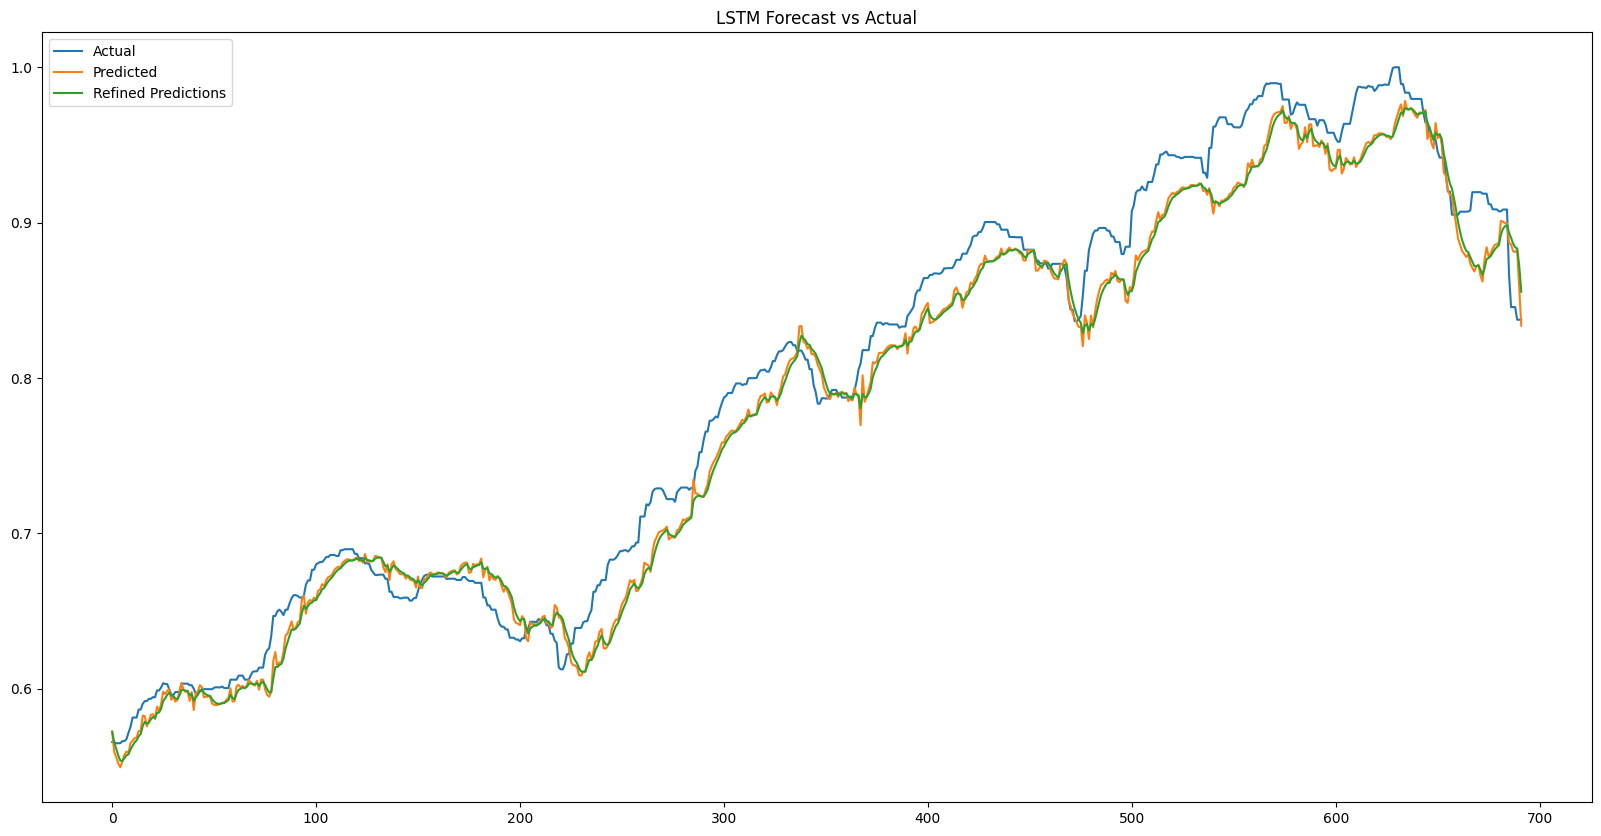

<Figure size 4000x1500 with 0 Axes>

[ 38  28 626]
[ 20   4 668]
[ 11  20 661]
Accuracy: 0.886
Accuracy smoothed: 0.886

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.11      0.14        38
           1       0.00      0.00      0.00        28
           2       0.91      0.97      0.94       626

    accuracy                           0.89       692
   macro avg       0.37      0.36      0.36       692
weighted avg       0.84      0.89      0.86       692


Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.11      0.16        38
           1       0.20      0.14      0.17        28
           2       0.92      0.97      0.94       626

    accuracy                           0.89       692
   macro avg       0.49      0.40      0.42       692
weighted avg       0.86      0.89      0.87       692



In [8]:


# Predict on the test set
price_pred, class_pred = lstm_model.predict(X_test_with_wavelet)
price_pred_transformed = scaler_y.inverse_transform(price_pred)
y_true = scaler_y.inverse_transform(y_test)
# Price predictions (regression)
price_pred = price_pred.flatten()  # Shape: (n_samples,)

# Class predictions (UP/DOWN/NEUTRAL)
class_pred = np.argmax(class_pred, axis=1)  # Shape: (n_samples,)
class_true = np.argmax(create_labels(y_test), axis=1)  # Assuming y_test is price values

kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=price_pred[0],
    initial_state_covariance=1.0,
    observation_covariance=0.3,
    transition_covariance=0.1
)
refined_predictions, _ = kf.filter(price_pred)

class_pred_smoothed = np.argmax(create_labels(refined_predictions), axis=1)  # Assuming y_test is price values

plt.figure(figsize=(20,10), dpi=100)
plt.plot(y_test, label='Actual')
plt.plot(price_pred, label='Predicted')
plt.plot(refined_predictions, label='Refined Predictions')
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.figure(figsize=(40,15))
plt.show()


print(np.bincount(class_true))
print(np.bincount(class_pred))
print(np.bincount(class_pred_smoothed))

accuracy = accuracy_score(class_true, class_pred)
print(f"Accuracy: {accuracy:.3f}")

accuracy = accuracy_score(class_true, class_pred_smoothed)
print(f"Accuracy smoothed: {accuracy:.3f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(class_true, class_pred))

print("\nClassification Report:")
print(classification_report(class_true, class_pred_smoothed))

              precision    recall  f1-score   support

           0       0.36      0.11      0.16        38
           1       0.20      0.14      0.17        28
           2       0.92      0.97      0.94       626

    accuracy                           0.89       692
   macro avg       0.49      0.40      0.42       692
weighted avg       0.86      0.89      0.87       692



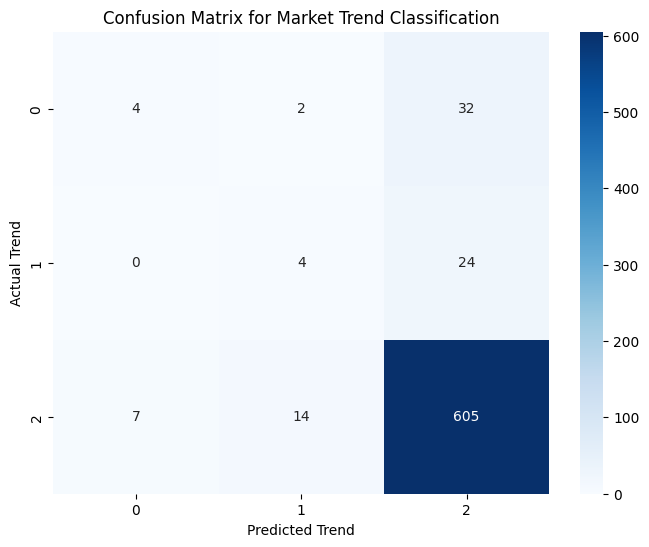

              precision    recall  f1-score   support

        Down       0.36      0.11      0.16        38
     Neutral       0.20      0.14      0.17        28
          Up       0.92      0.97      0.94       626

    accuracy                           0.89       692
   macro avg       0.49      0.40      0.42       692
weighted avg       0.86      0.89      0.87       692



In [9]:
import pandas as pd
from sklearn.metrics import classification_report
print(classification_report(class_true, class_pred_smoothed))
plt.figure(figsize=(8, 6))
conf_mat = pd.crosstab(
    pd.Series(class_true, name='Actual'),
    pd.Series(class_pred_smoothed, name='Predicted')
)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Market Trend Classification')
plt.xlabel('Predicted Trend')
plt.ylabel('Actual Trend')
plt.show()

print(classification_report(class_true, class_pred_smoothed, target_names=['Down', 'Neutral', 'Up']))

In [11]:
pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached sklearn_compat-0.1.3-py3-none-any.whl.metadata (18 kB)
Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
Using cached sklearn_compat-0.1.3-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from imblearn.over_sampling import ADASYN

def create_labels(y):
    labels = np.zeros((len(y), 3))
    for i in range(len(y) - 1):
        diff = y[i + 1] - y[i]
        if diff > 0.005:  # Threshold for UP
            labels[i, 0] = 1  # UP
        elif diff < -0.005:  # Threshold for DOWN
            labels[i, 1] = 1  # DOWN
        else:
            labels[i, 2] = 1  # NEUTRAL
    return labels


copy_features = ['SMA_crossover','SMA_17' ,'SMA_9','SMA_5','ATR_14', 'OBV', 'VWAP','Volume','BB_bandWidh','MACD','Volatility','Target']
original_index = data[copy_features].index.copy()

date_index = data.index.copy()
class_y = np.argmax(create_labels(data['Target']), axis=1)
class_y = pd.Series(class_y, index=original_index, name='Target_Class')  # convert to Series with name


# Combine features and labels
df = pd.concat([data[copy_features], class_y], axis=1)
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

features = ['SMA_crossover','SMA_17' ,'SMA_9','SMA_5','ATR_14', 'OBV', 'VWAP','Volume','BB_bandWidh','MACD','Volatility']
X = df[features]
y = df['Target_Class']

# Apply ADASYN
adasyn = ADASYN(n_neighbors=1,random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

y_resampled.value_counts()

/var/folders/k9/ywt32ng54d766jxqldqb4y7c0000gn/T/ipykernel_99000/3765722823.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = y[i + 1] - y[i]


Target_Class
2    2306
0    2305
1    2103
Name: count, dtype: int64

In [22]:

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_resampled)
y_scaled = scaler_y.fit_transform(y_resampled.values.reshape(-1, 1))
sequence_length =3
# Step 7: Sequence formatting for LSTM-like models
X_reshaped = np.array([X_scaled[i-sequence_length:i] for i in range(sequence_length, len(X_scaled))])
y_reshaped = y_scaled[sequence_length:]

split = int(0.9 * len(X_reshaped))
X_train_t, X_test = X_reshaped[:split], X_reshaped[split:]
y_train_t, y_test = y_reshaped[:split], y_reshaped[split:]

split = int(0.9 * len(X_train_t))
X_train, X_val = X_train_t[:split], X_train_t[split:]
y_train, y_val = y_train_t[:split], y_train_t[split:]

y_train_class = create_labels(y_train)
y_val_class = create_labels(y_val)
y_test_class = create_labels(y_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Final sanity check
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

num_features = X_train.shape[2]  # e.g., 12

# Add Wavelet Features
prices = df_upsampled['Target'].values
n = len(prices)
coeffs = pywt.wavedec(prices, 'db1', level=5)
reconstructed_details = []
for level in range(1, len(coeffs)):
    coeff_reconstruct = [np.zeros_like(c) for c in coeffs]
    coeff_reconstruct[level] = coeffs[level]
    coeff_reconstruct[0] = np.zeros_like(coeffs[0])
    reconstructed = pywt.waverec(coeff_reconstruct, 'db1')[:n]
    reconstructed_details.append(reconstructed)
wavelet_features = np.stack(reconstructed_details, axis=1)

# Align wavelet features with each split
wavelet_features_train = wavelet_features[-X_train.shape[0]:]
wavelet_features_test = wavelet_features[-X_test.shape[0]:]
wavelet_features_val = wavelet_features[-X_val.shape[0]:]

# Expand for sequence length
wavelet_features_train_expanded = np.repeat(wavelet_features_train[:, np.newaxis, :], X_train.shape[1], axis=1)
wavelet_features_test_expanded = np.repeat(wavelet_features_test[:, np.newaxis, :], X_test.shape[1], axis=1)
wavelet_features_val_expanded = np.repeat(wavelet_features_val[:, np.newaxis, :], X_val.shape[1], axis=1)

# Concatenate with input data
X_train_with_wavelet = np.concatenate([X_train, wavelet_features_train_expanded], axis=2)
X_test_with_wavelet = np.concatenate([X_test, wavelet_features_test_expanded], axis=2)
X_val_with_wavelet = np.concatenate([X_val, wavelet_features_val_expanded], axis=2)
num_features = X_train_with_wavelet.shape[2]

print("X_train_with_wavelet shape:", X_train_with_wavelet.shape)
print("X_val_with_wavelet shape:", X_val_with_wavelet.shape)        
print("X_test_with_wavelet shape:", X_test_with_wavelet.shape)


X_train shape: (5435, 3, 11)
y_train shape: (5435, 1)
X_val shape: (604, 3, 11)
y_val shape: (604, 1)
X_test shape: (672, 3, 11)
y_test shape: (672, 1)
X_train_with_wavelet shape: (5435, 3, 16)
X_val_with_wavelet shape: (604, 3, 16)
X_test_with_wavelet shape: (672, 3, 16)


In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Create and train model
sequence_length = 3
lstm_model_adasyn = create_lstm_model(units=128, dropout_rate=0.2, sequence_length=sequence_length, num_features=num_features, num_wavelet_features=5)
lstm_model_adasyn.fit(X_train_with_wavelet, {'price': y_train, 'class': y_train_class},
          validation_data=(X_val_with_wavelet, {'price': y_val, 'class': y_val_class}),
          epochs=50, batch_size=16,callbacks=[early_stopping, reduce_lr])


Creating LSTM model with units: 128 and dropout rate: 0.2 for sequence length: 3 and num features: 16
Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 65s 171ms/step - class_accuracy: 0.7543 - class_loss: 0.0463 - loss: 1.0063 - price_loss: 0.9599 - price_mae: 0.2991 - val_class_accuracy: 0.9983 - val_class_loss: 0.0103 - val_loss: 0.9912 - val_price_loss: 0.9865 - val_price_mae: 0.4194 - learning_rate: 5.0000e-04
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - class_accuracy: 0.8300 - class_loss: 0.0356 - loss: 0.6073 - price_loss: 0.5717 - price_mae: 0.2474 - val_class_accuracy: 0.9983 - val_class_loss: 0.0030 - val_loss: 0.6183 - val_price_loss: 0.6183 - val_price_mae: 0.3213 - learning_rate: 5.0000e-04
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 41s 120ms/step - class_accuracy: 0.8412 - class_loss: 0.0331 - loss: 0.5222 - price_loss: 0.4891 - price_mae: 0.2323 - val_class_accuracy: 0.9983 - val_class_loss: 0.0036 - val_loss: 0.2938 - val_price_loss: 0.2932 - val_price_mae: 0.2014 - lea

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


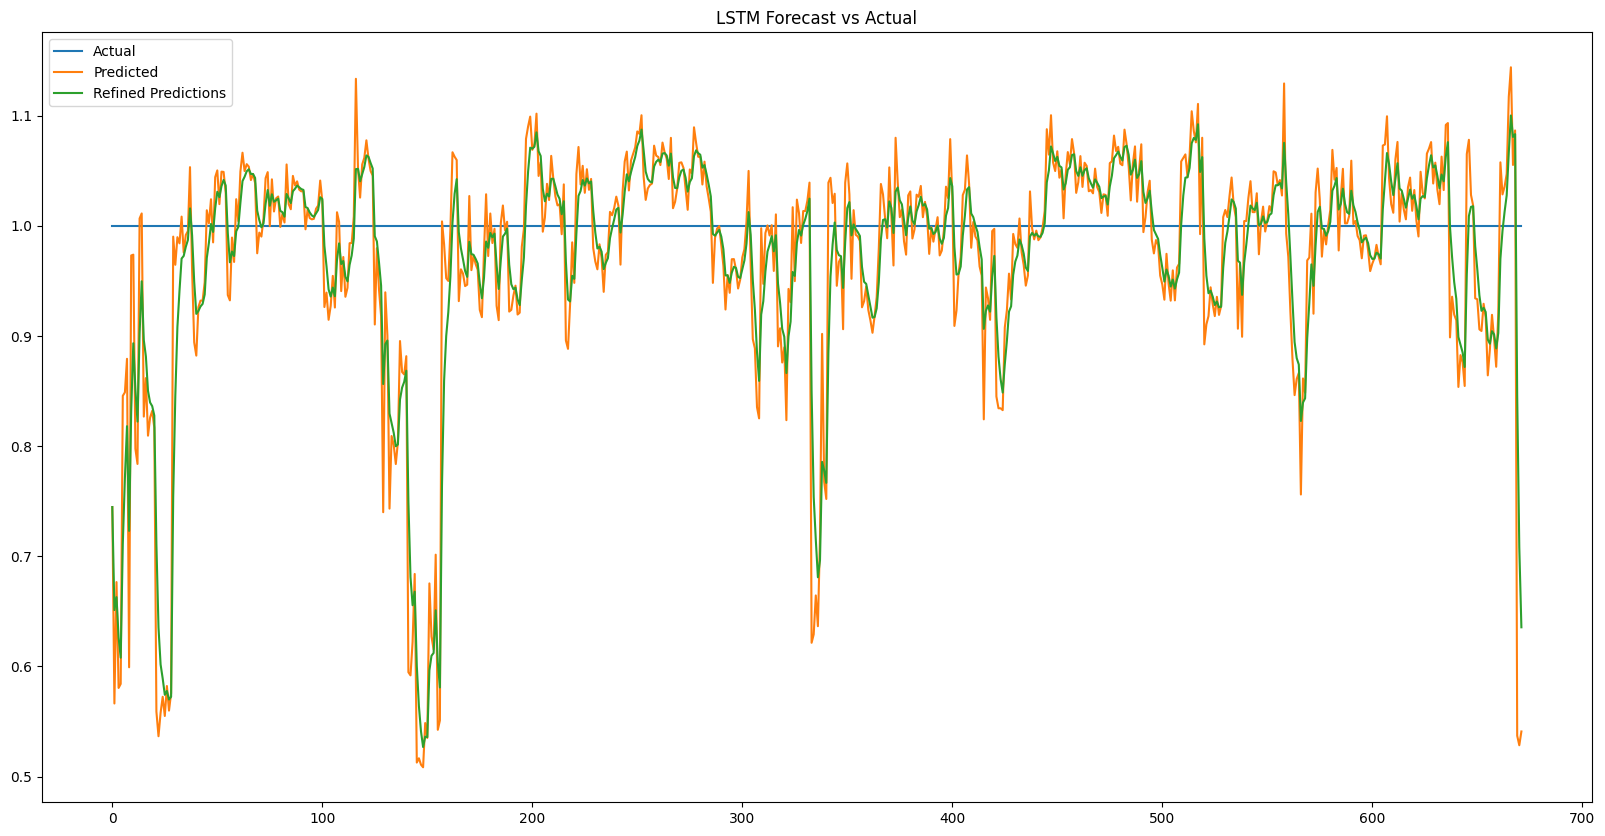

<Figure size 4000x1500 with 0 Axes>

[  1   0 671]
[  0   0 672]
[232 228 212]
Accuracy: 0.999
Accuracy smoothed: 0.317

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       1.00      1.00      1.00       671

    accuracy                           1.00       672
   macro avg       0.50      0.50      0.50       672
weighted avg       1.00      1.00      1.00       672


Classification Report:
              precision    recall  f1-score   support

           0       0.00      1.00      0.01         1
           1       0.00      0.00      0.00         0
           2       1.00      0.32      0.48       671

    accuracy                           0.32       672
   macro avg       0.33      0.44      0.16       672
weighted avg       1.00      0.32      0.48       672



/opt/anaconda3/envs/PPOAgent/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/PPOAgent/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/PPOAgent/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [24]:


# Predict on the test set
price_pred, class_pred = lstm_model_adasyn.predict(X_test_with_wavelet)
price_pred_transformed = scaler_y.inverse_transform(price_pred)
y_true = scaler_y.inverse_transform(y_test)
# Price predictions (regression)
price_pred = price_pred.flatten()  # Shape: (n_samples,)

# Class predictions (UP/DOWN/NEUTRAL)
class_pred = np.argmax(class_pred, axis=1)  # Shape: (n_samples,)
class_true = np.argmax(create_labels(y_test), axis=1)  # Assuming y_test is price values

kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=price_pred[0],
    initial_state_covariance=1.0,
    observation_covariance=0.3,
    transition_covariance=0.1
)
refined_predictions, _ = kf.filter(price_pred)

class_pred_smoothed = np.argmax(create_labels(refined_predictions), axis=1)  # Assuming y_test is price values

plt.figure(figsize=(20,10), dpi=100)
plt.plot(y_test, label='Actual')
plt.plot(price_pred, label='Predicted')
plt.plot(refined_predictions, label='Refined Predictions')
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.figure(figsize=(40,15))
plt.show()


print(np.bincount(class_true))
print(np.bincount(class_pred))
print(np.bincount(class_pred_smoothed))

accuracy = accuracy_score(class_true, class_pred)
print(f"Accuracy: {accuracy:.3f}")

accuracy = accuracy_score(class_true, class_pred_smoothed)
print(f"Accuracy smoothed: {accuracy:.3f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(class_true, class_pred))

print("\nClassification Report:")
print(classification_report(class_true, class_pred_smoothed))

In [26]:
from imblearn.over_sampling import ADASYN
import pandas as pd
import numpy as np

# Assume X and y are defined, with datetime index
X = data[features]
y = np.argmax(create_labels(data['Target']), axis=1)
original_index = X.index.copy()

# Apply ADASYN
adasyn = ADASYN(n_neighbors=1, random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Figure out how many new (synthetic) samples were added
n_original = len(X)
n_resampled = len(X_resampled)
n_synthetic = n_resampled - n_original

# Step 1: Keep the original datetime index
original_datetime_index = original_index

# Step 2: Create new datetime index for synthetic samples
# Strategy: Add a fixed timedelta (e.g. 1 minute) to last timestamp repeatedly
last_time = original_datetime_index[-1]
synthetic_times = pd.date_range(start=last_time + pd.Timedelta(minutes=1),
                                periods=n_synthetic,
                                freq='T')  # You can change this frequency to match your dataset

# Step 3: Combine indexes
new_index = original_datetime_index.tolist() + synthetic_times.tolist()

# Step 4: Reconstruct X and y with the new index
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns, index=new_index)
y_resampled_series = pd.Series(y_resampled, name='Target_Class', index=new_index)


/var/folders/k9/ywt32ng54d766jxqldqb4y7c0000gn/T/ipykernel_99000/3765722823.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diff = y[i + 1] - y[i]
/var/folders/k9/ywt32ng54d766jxqldqb4y7c0000gn/T/ipykernel_99000/610210053.py:25: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  synthetic_times = pd.date_range(start=last_time + pd.Timedelta(minutes=1),


In [27]:

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_resampled_df)
y_scaled = scaler_y.fit_transform(y_resampled_series.values.reshape(-1, 1))
sequence_length =3
# Step 7: Sequence formatting for LSTM-like models
X_reshaped = np.array([X_scaled[i-sequence_length:i] for i in range(sequence_length, len(X_scaled))])
y_reshaped = y_scaled[sequence_length:]

split = int(0.9 * len(X_reshaped))
X_train_t, X_test = X_reshaped[:split], X_reshaped[split:]
y_train_t, y_test = y_reshaped[:split], y_reshaped[split:]

split = int(0.9 * len(X_train_t))
X_train, X_val = X_train_t[:split], X_train_t[split:]
y_train, y_val = y_train_t[:split], y_train_t[split:]

y_train_class = create_labels(y_train)
y_val_class = create_labels(y_val)
y_test_class = create_labels(y_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Final sanity check
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

num_features = X_train.shape[2]  # e.g., 12

# Add Wavelet Features
prices = df_upsampled['Target'].values
n = len(prices)
coeffs = pywt.wavedec(prices, 'db1', level=5)
reconstructed_details = []
for level in range(1, len(coeffs)):
    coeff_reconstruct = [np.zeros_like(c) for c in coeffs]
    coeff_reconstruct[level] = coeffs[level]
    coeff_reconstruct[0] = np.zeros_like(coeffs[0])
    reconstructed = pywt.waverec(coeff_reconstruct, 'db1')[:n]
    reconstructed_details.append(reconstructed)
wavelet_features = np.stack(reconstructed_details, axis=1)

# Align wavelet features with each split
wavelet_features_train = wavelet_features[-X_train.shape[0]:]
wavelet_features_test = wavelet_features[-X_test.shape[0]:]
wavelet_features_val = wavelet_features[-X_val.shape[0]:]

# Expand for sequence length
wavelet_features_train_expanded = np.repeat(wavelet_features_train[:, np.newaxis, :], X_train.shape[1], axis=1)
wavelet_features_test_expanded = np.repeat(wavelet_features_test[:, np.newaxis, :], X_test.shape[1], axis=1)
wavelet_features_val_expanded = np.repeat(wavelet_features_val[:, np.newaxis, :], X_val.shape[1], axis=1)

# Concatenate with input data
X_train_with_wavelet = np.concatenate([X_train, wavelet_features_train_expanded], axis=2)
X_test_with_wavelet = np.concatenate([X_test, wavelet_features_test_expanded], axis=2)
X_val_with_wavelet = np.concatenate([X_val, wavelet_features_val_expanded], axis=2)
num_features = X_train_with_wavelet.shape[2]

print("X_train_with_wavelet shape:", X_train_with_wavelet.shape)
print("X_val_with_wavelet shape:", X_val_with_wavelet.shape)        
print("X_test_with_wavelet shape:", X_test_with_wavelet.shape)


X_train shape: (5435, 3, 11)
y_train shape: (5435, 1)
X_val shape: (604, 3, 11)
y_val shape: (604, 1)
X_test shape: (672, 3, 11)
y_test shape: (672, 1)
X_train_with_wavelet shape: (5435, 3, 16)
X_val_with_wavelet shape: (604, 3, 16)
X_test_with_wavelet shape: (672, 3, 16)


/opt/anaconda3/envs/PPOAgent/lib/python3.12/site-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/opt/anaconda3/envs/PPOAgent/lib/python3.12/site-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Create and train model
sequence_length = 3
lstm_model_adasyn = create_lstm_model(units=128, dropout_rate=0.2, sequence_length=sequence_length, num_features=num_features, num_wavelet_features=5)
lstm_model_adasyn.fit(X_train_with_wavelet, {'price': y_train, 'class': y_train_class},
          validation_data=(X_val_with_wavelet, {'price': y_val, 'class': y_val_class}),
          epochs=50, batch_size=16,callbacks=[early_stopping, reduce_lr])


Creating LSTM model with units: 128 and dropout rate: 0.2 for sequence length: 3 and num features: 16
Epoch 1/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - class_accuracy: 0.0000e+00 - class_loss: 7.9718 - loss: nan - price_loss: nan - price_mae: nan - val_class_accuracy: 0.0000e+00 - val_class_loss: 7.9799 - val_loss: nan - val_price_loss: nan - val_price_mae: nan - learning_rate: 5.0000e-04
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 34s 99ms/step - class_accuracy: 0.0000e+00 - class_loss: 7.9720 - loss: nan - price_loss: nan - price_mae: nan - val_class_accuracy: 0.0000e+00 - val_class_loss: 7.9799 - val_loss: nan - val_price_loss: nan - val_price_mae: nan - learning_rate: 5.0000e-04
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - class_accuracy: 0.0000e+00 - class_loss: 7.9721 - loss: nan - price_loss: nan - price_mae: nan - val_class_accuracy: 0.0000e+00 - val_class_loss: 7.9799 - val_loss: nan - val_price_loss: nan - val_price_mae: nan - learning_rate: 5.0000e-04
Epoch 4/

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


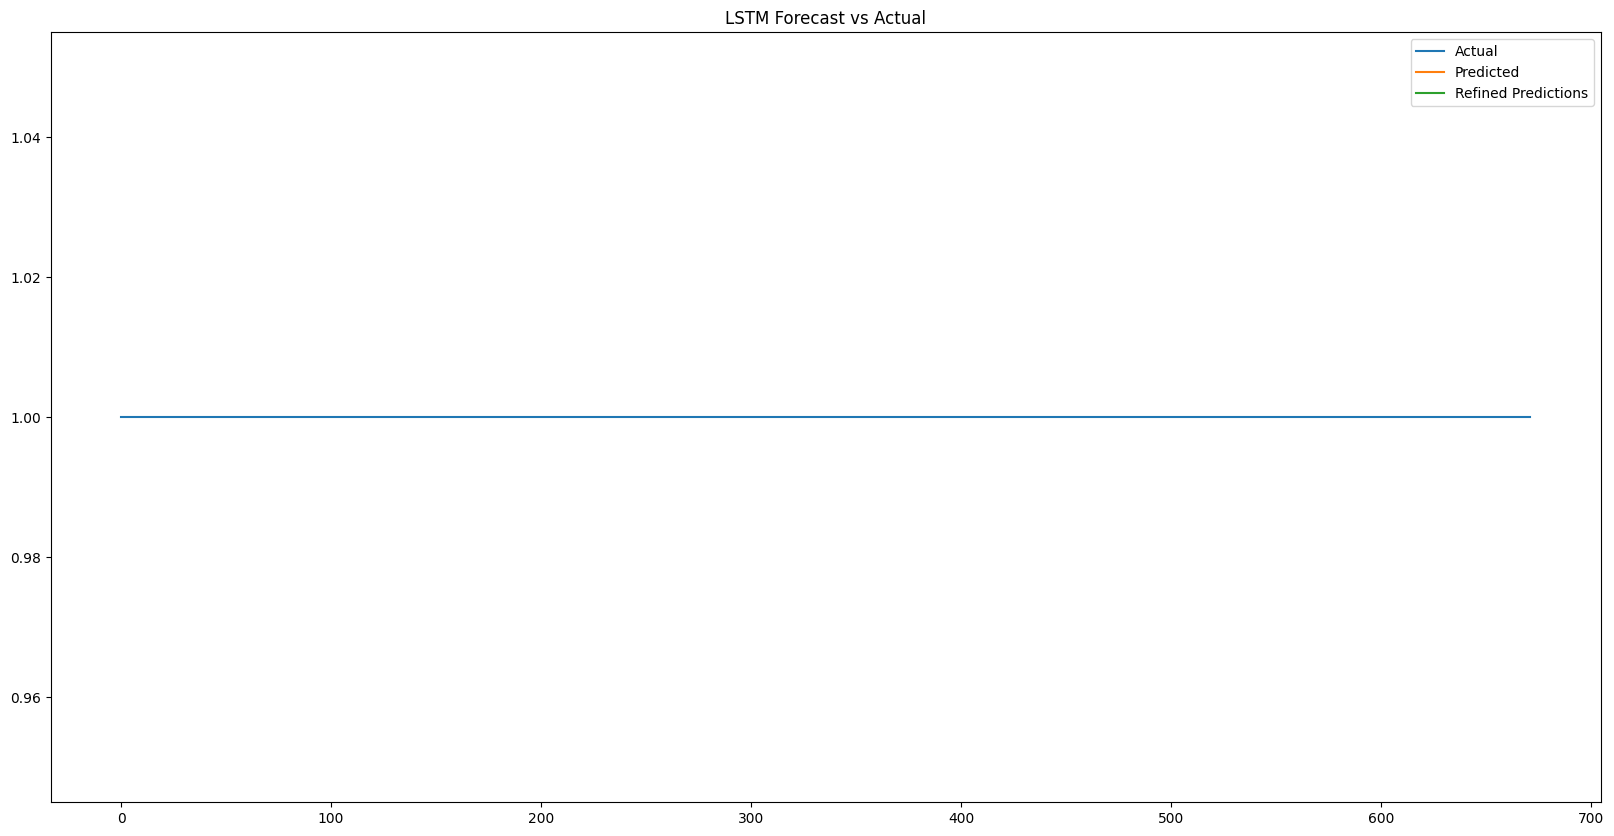

<Figure size 4000x1500 with 0 Axes>

[  1   0 671]
[672]
[  1   0 671]
Accuracy: 0.001
Accuracy smoothed: 1.000

Classification Report:
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         1
           2       0.00      0.00      0.00       671

    accuracy                           0.00       672
   macro avg       0.00      0.50      0.00       672
weighted avg       0.00      0.00      0.00       672


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           2       1.00      1.00      1.00       671

    accuracy                           1.00       672
   macro avg       1.00      1.00      1.00       672
weighted avg       1.00      1.00      1.00       672



/opt/anaconda3/envs/PPOAgent/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/PPOAgent/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/PPOAgent/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [29]:


# Predict on the test set
price_pred, class_pred = lstm_model_adasyn.predict(X_test_with_wavelet)
price_pred_transformed = scaler_y.inverse_transform(price_pred)
y_true = scaler_y.inverse_transform(y_test)
# Price predictions (regression)
price_pred = price_pred.flatten()  # Shape: (n_samples,)

# Class predictions (UP/DOWN/NEUTRAL)
class_pred = np.argmax(class_pred, axis=1)  # Shape: (n_samples,)
class_true = np.argmax(create_labels(y_test), axis=1)  # Assuming y_test is price values

kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=price_pred[0],
    initial_state_covariance=1.0,
    observation_covariance=0.3,
    transition_covariance=0.1
)
refined_predictions, _ = kf.filter(price_pred)

class_pred_smoothed = np.argmax(create_labels(refined_predictions), axis=1)  # Assuming y_test is price values

plt.figure(figsize=(20,10), dpi=100)
plt.plot(y_test, label='Actual')
plt.plot(price_pred, label='Predicted')
plt.plot(refined_predictions, label='Refined Predictions')
plt.legend()
plt.title("LSTM Forecast vs Actual")
plt.figure(figsize=(40,15))
plt.show()


print(np.bincount(class_true))
print(np.bincount(class_pred))
print(np.bincount(class_pred_smoothed))

accuracy = accuracy_score(class_true, class_pred)
print(f"Accuracy: {accuracy:.3f}")

accuracy = accuracy_score(class_true, class_pred_smoothed)
print(f"Accuracy smoothed: {accuracy:.3f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(class_true, class_pred))

print("\nClassification Report:")
print(classification_report(class_true, class_pred_smoothed))